# Introduction

This notebook takes a first step in the approach to brain tumor analysis that we indicated in the lecture, where a heterogeneous set of sources is used as inputs to a single predictive model:

<img width=60% src="assets/pathnet.png">

Remember that the approach was based on the work of the following two papers:
- [1] Chen, Richard J., et al. "Pathomic fusion: an integrated framework for fusing histopathology and genomic features for cancer diagnosis and prognosis." IEEE Transactions on Medical Imaging (2020). https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9186053
- [2] Mobadersany, Pooya, et al. "Predicting cancer outcomes from histology and genomics using convolutional networks." Proceedings of the National Academy of Sciences 115.13 (2018): E2970-E2979. https://www.pnas.org/content/pnas/115/13/E2970.full.pdf

This notebook creates the CNN model tasked with predicting the tumor grade from histology. We'll also extract features from this model, which is a first step towards fusing with other sources of information. Along the way we'll have a look at _class activation maps_, a useful model interpretation technique from "Explainable AI".

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, 
#as that makes some difference for the code below.
try:
    import colab
    colab=True
except:
    colab=False

> **Warning**: This notebook will take a long time to run on Google Colab as the data set is quite big. 

In [2]:
if colab:
    !pip install -Uqq fastbook
    !pip install fastai-amalgam
    !pip install palettable
    !pip install matplotlib_venn
    import fastbook
    fastbook.setup_book()
    from fastbook import *

In [3]:
%matplotlib inline
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from fastai.vision.all import *
import gc
import os, sys
#sys.path.append("../")

from some_utils import plot_metrics

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
%config Completer.use_jedi = False

In [6]:
pd.set_option('display.max_columns', 500)

In [7]:
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    IMGDATA = Path("/content/gdrive/MyDrive/Colab Notebooks/data")
if not colab:
    IMGDATA = Path.home()/'data-tmp/TCGA-images' # You can change this if you want to store data elsewhere
    
    
IMGDATA.mkdir(exist_ok=True, parents=True)
NB_DIR = Path.cwd()

# Download data

In [8]:
imgdataurl = 'https://www.dropbox.com/s/jka111c16q8cn6x/PNAS-images.zip?dl=1'
dataurl = 'https://www.dropbox.com/s/zogil8mxr2p9ajy/pathfusion.zip?dl=1'

_The following cell will take some time to run. The image data set is approx. 3.7 GB_

In [9]:
if not os.path.isfile(IMGDATA/'PNAS-images.zip'):
    urllib.request.urlretrieve(imgdataurl, IMGDATA/'PNAS-images.zip')

In [10]:
if len(IMGDATA.ls(file_exts='.png')) < 10: 
    shutil.unpack_archive(IMGDATA/'PNAS-images.zip', extract_dir=IMGDATA)

In [11]:
if not os.path.isfile(IMGDATA/'pathfusion.zip'):
    urllib.request.urlretrieve(dataurl, IMGDATA/'pathfusion.zip')
    shutil.unpack_archive(IMGDATA/'pathfusion.zip', extract_dir=IMGDATA)

# Explore data

> To compare our results with those in [1] we use the same cross-validation splits (which are originally taken from [2]). We ensure this by using the data prepared and processed by [1] and linked from their GitHub repository (https://github.com/mahmoodlab/PathomicFusion), combined with the histological images from TCGA-GBM made available by [2]. The data from [1] was extracted and combined into a .csv file stored under the LOCALDATA directory.  

In [12]:
IMGDATA.ls()

(#1511) [Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-R8-A6MK-01Z-00-DXF.F23D5126-9D7D-436E-9565-5724CDFDD79E_1.png'),Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-02-0009-01Z-00-DX3.BAA1276B-E4D7-43D4-BDDF-807532462518_2.png'),Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-RY-A847-01Z-00-DX1.E137897D-0B07-401B-A106-BFF78C14F5D4_1.png'),Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-DU-7007-01Z-00-DX1.DB64D884-B8AA-4540-BF6F-BF83B1D15A26_1.png'),Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-QH-A6X4-01Z-00-DX1.59C962C6-B2F6-4156-BA5F-ADAEF54BA4D8_1.png'),Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-DB-5274-01Z-00-DX2.958D3EC3-7E76-4E0D-ACB2-BA67196DAB75_3.png'),Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-DB-A64U-01Z-00-DX1.7E003533-C514-46BA-A934-3D74B19188DE_1.png'),Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-HW-7489-01Z-00-DX1.4586f9f6-ff9b-4966-a487-769d135024dd_2.png'),Path('/home/ubuntu/data-tmp/TCGA-images/TCGA-14-0789-01Z-00-DX4.76e3eef7-b6ee-45aa-9ada-24e48da42be4_1.png'),Path('/hom

In [13]:
df = pd.read_csv(IMGDATA/'tmidata_000_cv_splits_img.csv')

In [14]:
df.head()

,TCGA ID,Histomolecular subtype,Histology,Grade,Molecular subtype,censored,Survival months,imgs,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15
0,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0
4,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0


In [15]:
print(f"There are {len(df['TCGA ID'].unique())} subjects")

There are 769 subjects


Tumor grades:

In [16]:
df["Grade"].value_counts()

 2.0    654
 1.0    408
 0.0    396
-1.0     47
Name: Grade, dtype: int64

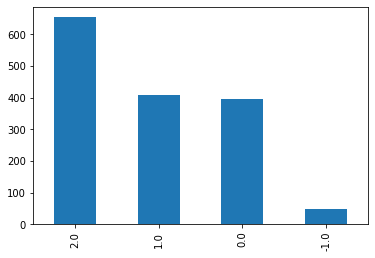

In [17]:
df["Grade"].value_counts().plot(kind='bar')
plt.show()

`-1` means that the grade information is missing. 

In [18]:
print(f"There are {len(df['TCGA ID'].unique())-len(df.loc[df['Grade'] == -1])} subjects with grade information")

There are 722 subjects with grade information


Note that there are multiple images belonging to a single TCGA ID. These are different views on the same tumor. For simplicity, we're going to treat each image as an independent training sample. Note that this is not optimal! The different views may correspond to different grades. 

# Preparing the data

To predict the tumor grade we need to set up our model $y \approx f(X, \theta)$. 

$X$ consists of the images for which we want to predict the grade, whose "ground truth" values are stored in $y$. 

As noted, grade information for some of the subjects is missing. We drop the corresponding rows:

In [19]:
df.drop(df.loc[df['Grade']==-1].index, inplace=True)

In [20]:
df.Grade.value_counts()

2.0    654
1.0    408
0.0    396
Name: Grade, dtype: int64

> For now we're going to ignore the cross-validation splits and just split off a random set of TCGA IDs to use for validation, stratified by the tumor grade (to have the same distribution of tumor grades in the validation set as in the training set). We'll get back to cross validation later. 

In [21]:
df_comb = df.drop_duplicates(subset='TCGA ID', keep='first')

In [22]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736 entries, 0 to 1498
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TCGA ID                 736 non-null    object 
 1   Histomolecular subtype  736 non-null    object 
 2   Histology               736 non-null    int64  
 3   Grade                   736 non-null    float64
 4   Molecular subtype       736 non-null    int64  
 5   censored                736 non-null    int64  
 6   Survival months         736 non-null    int64  
 7   imgs                    736 non-null    object 
 8   cv_1                    736 non-null    int64  
 9   cv_2                    736 non-null    int64  
 10  cv_3                    736 non-null    int64  
 11  cv_4                    736 non-null    int64  
 12  cv_5                    736 non-null    int64  
 13  cv_6                    736 non-null    int64  
 14  cv_7                    736 non-null    i

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train, val = train_test_split(df_comb['TCGA ID'], stratify=df_comb['Grade'], 
                              test_size=0.2, random_state=42)

In [25]:
train = df.loc[df['TCGA ID'].isin(train)]
val = df.loc[df['TCGA ID'].isin(val)]

In [27]:
train['is_valid'] = False
val['is_valid'] = True
df = pd.concat([train, val])

In [28]:
df.head()

,TCGA ID,Histomolecular subtype,Histology,Grade,Molecular subtype,censored,Survival months,imgs,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15,is_valid
3,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,False
4,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,False
5,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX1.6171b175-0972-4e84-9997-2f1ce75f4407_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,False
6,TCGA-02-0006,idhwt_ATC,3,2.0,0,1,558,TCGA-02-0006-01Z-00-DX1.a37df719-8b93-4245-ae49-67eb1114253a_1.png,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,False
7,TCGA-02-0007,idhwt_ATC,3,2.0,0,1,705,TCGA-02-0007-01Z-00-DX1.a888f75e-6c41-44c3-8eb6-721f992873b8_1.png,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,False


In [29]:
df.is_valid.value_counts()

False    1166
True      292
Name: is_valid, dtype: int64

# Predict tumor grade

As a test we'll try to predict the tumor grade directly from the images.

## Create dataloaders

In [30]:
dls = ImageDataLoaders.from_df(
    df, path=IMGDATA, fn_col='imgs', label_col='Grade', 
    valid_col='is_valid',
    item_tfms=Resize(1024, method='zeros'), # Note: not necessary in this case as the images are already 1024x1024
    batch_tfms=[Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), 
                Normalize.from_stats(*imagenet_stats), 
                Resize(900, method='zeros')])

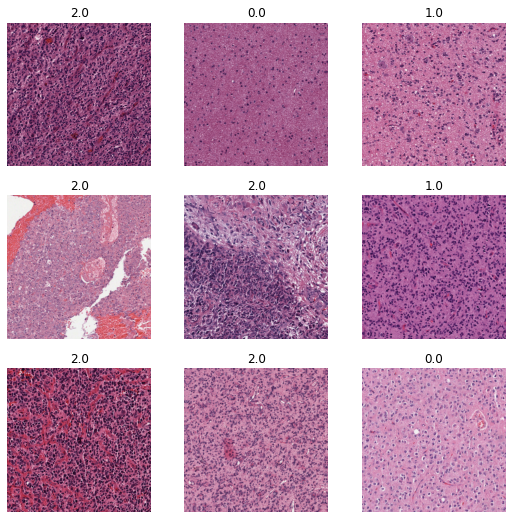

In [31]:
dls.show_batch()

Here are some results from the data augmentation applied to a single image:

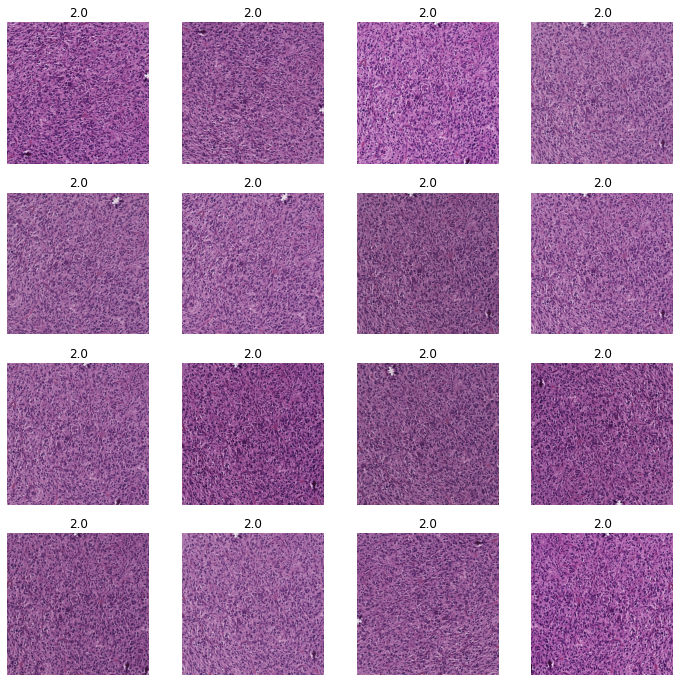

In [32]:
dls.show_batch(unique=True, max_n=16, figsize=(12,12))

## Create and train model

In [33]:
learn = cnn_learner(
    dls, arch=resnet18, 
    metrics=[accuracy, RocAuc(), F1Score(average='micro'), F1Score(average=None)], 
    path='.', 
    pretrained=True, wd=1e-4).to_fp16()

In [ ]:
# As the training takes some time we can rather load a model trained ahead of time:
#learn = learn.load('grade_class_model')

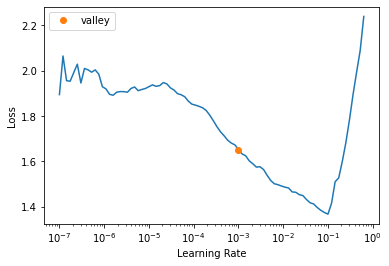

In [34]:
lr = learn.lr_find()

In [35]:
lr = lr.valley
lr

0.0010000000474974513

In [36]:
learn.fine_tune(8, base_lr=lr)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.400280,0.591213,0.722603,0.901092,0.722603,[0.7 0.5497076 0.86695279],00:26


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.880375,0.622499,0.726027,0.878652,0.726027,[0.63030303 0.55294118 0.90763052],00:28
1,0.892891,0.588065,0.770548,0.897111,0.770548,[0.71428571 0.62275449 0.90763052],00:26
2,0.837101,0.616319,0.791096,0.891351,0.791096,[0.72189349 0.66666667 0.92 ],00:26
3,0.749916,0.599040,0.780822,0.905732,0.780822,[0.73988439 0.59459459 0.91254753],00:26
4,0.678733,0.609894,0.777397,0.894994,0.777397,[0.7030303 0.62576687 0.921875 ],00:26
5,0.646018,0.605786,0.773973,0.895457,0.773973,[0.68604651 0.60493827 0.944 ],00:26
6,0.611955,0.615402,0.753425,0.888998,0.753425,[0.65060241 0.58682635 0.93227092],00:26
7,0.579429,0.612852,0.760274,0.890055,0.760274,[0.6626506 0.58024691 0.9375 ],00:26


/home/ubuntu/anaconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


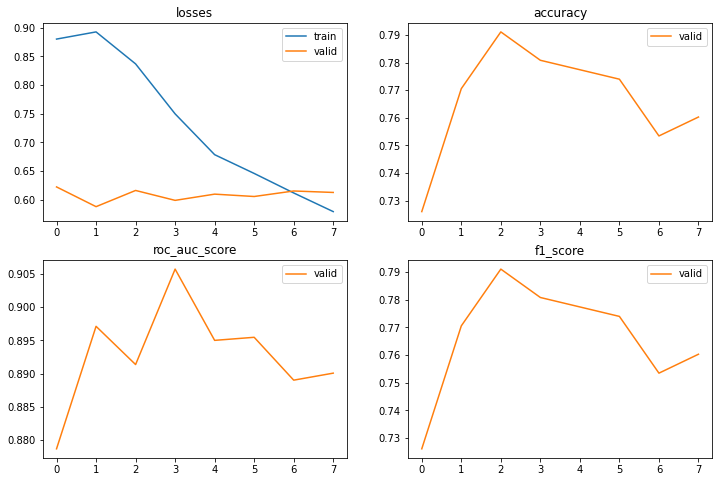

In [37]:
learn.recorder.plot_metrics(endnames=-2)

In [ ]:
#learn.save('grade_class_model')

## TTA: Test-time augmentation

Here's a trick that can potentially improve predictions on test data: make multiple predictions per test image using the data augmentation set up during training to make several somewhat independent predictions per image:

In [38]:
y_pred, y_test = learn.tta(n=10)

In [39]:
accuracy(y_pred, y_test).item()

0.7773972749710083

Note that this is also sometimes used to get some handle on the model **uncertainty**. The variation in the model confidence across the different, slightly transformed inputs derived from a single image can be used as an uncertainty measure. 

## Progressive resizing

In [46]:
# Free up memory:
learn=None
gc.collect()
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

Note that as you continue training the model, the training loss will become quite a bit lower than the validation loss. Which is not in itself a problem, but there are tricks that can in a sense deal with this, and that can sometimes lead to better results.. **Progressive resizing** is one such trick.

By first training on a small version of the images and then progressively on larger and larger images one can often improve performance. In a sense you're pretraining the model on data that's very similar, yet different, to the target data set. 

In [47]:
def get_dls(bs, sz):
    dls = ImageDataLoaders.from_df(
        df, path=IMGDATA, fn_col='imgs', label_col='Grade', 
        valid_col='is_valid', bs=bs,
        item_tfms=Resize(1024, method='zeros'), 
        batch_tfms=[Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), 
                    Normalize.from_stats(*imagenet_stats), 
                    Resize(sz, method='zeros')])
    return dls

### Size 256x256

In [48]:
dls = get_dls(64, 256)

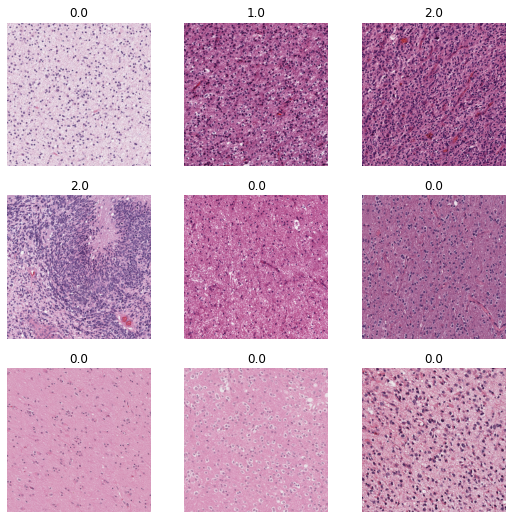

In [49]:
dls.show_batch()

In [50]:
learn = cnn_learner(
    dls, arch=resnet18, 
    metrics=[accuracy, RocAuc(), F1Score(average='micro'), F1Score(average=None)], 
    path='.', 
    pretrained=True, wd=1e-4).to_fp16()

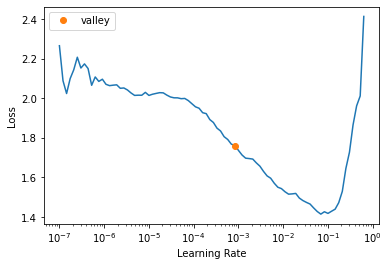

In [51]:
lr = learn.lr_find()

In [52]:
lr = lr.valley

In [54]:
lr

0.0008317637839354575

In [53]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.372110,0.692485,0.715753,0.887460,0.715753,[0.71219512 0.47887324 0.86075949],00:24
1,1.110411,0.647545,0.729452,0.876035,0.729452,[0.63030303 0.56287425 0.9047619 ],00:24
2,0.953949,0.631559,0.746575,0.888311,0.746575,[0.67080745 0.58181818 0.89922481],00:24


## Size 1024x1024

In [55]:
learn.dls = get_dls(32, 1024)

In [56]:
learn.fine_tune(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.796759,0.629085,0.746575,0.891680,0.746575,[0.66242038 0.59036145 0.89655172],00:23


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.846043,0.635926,0.739726,0.887749,0.739726,[0.64102564 0.58682635 0.89655172],00:24
1,0.857020,0.609684,0.767123,0.895106,0.767123,[0.73333333 0.58278146 0.90118577],00:22
2,0.844434,0.597054,0.767123,0.895540,0.767123,[0.69565217 0.61818182 0.90697674],00:22
3,0.817947,0.600013,0.763699,0.894897,0.763699,[0.70658683 0.6 0.90272374],00:22
4,0.786900,0.588943,0.770548,0.897243,0.770548,[0.7030303 0.62195122 0.90980392],00:22


## Mixup and CutMix

Finally, here are two other ideas that can lead to improved results in certain cases. 

<img width=80% src="assets/mixup.png">

<img width=80% src="assets/cutmix.png">

<img src="assets/mixup-cutmix.png">

<img src="assets/mixup2.png">

In [ ]:
dls = get_dls(32, 1024)

In [ ]:
mixup = MixUp(alpha=1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn_m:
    learn_m.epoch,learn_m.training = 0,True
    learn_m.dl = dls.train
    b = dls.one_batch()
    learn_m._split(b)
    learn_m('before_train')
    learn_m('before_batch')

In [ ]:
_,axs = plt.subplots(2,2, figsize=(12,12))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

In [ ]:
cutmix = CutMix(alpha=1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn_c:
    learn_c.epoch,learn_c.training = 0,True
    learn_c.dl = dls.train
    b = dls.one_batch()
    learn_c._split(b)
    learn_c('before_train')
    learn_c('before_batch')

In [ ]:
_,axs = plt.subplots(2,2, figsize=(12,12))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

**MixUp:**

In [63]:
learn_mu = cnn_learner(
    dls, arch=resnet18, 
    metrics=[accuracy, RocAuc(), F1Score(average='micro'), F1Score(average=None)], 
    path='.', wd=1e-4, cbs=MixUp())

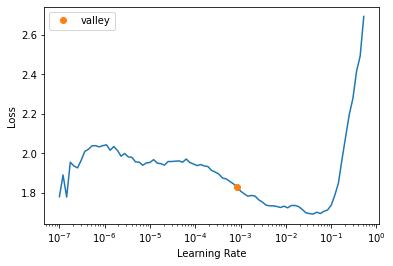

In [64]:
lr = learn_mu.lr_find()

In [65]:
lr = lr.valley
lr

0.0008317637839354575

In [42]:
learn_mu.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.478586,0.713132,0.743151,0.873949,0.743151,[0.70351759 0.54545455 0.89256198],00:24
1,1.306022,0.753557,0.708904,0.869994,0.708904,[0.5890411 0.58585859 0.88333333],00:24
2,1.182688,0.724046,0.678082,0.846265,0.678082,[0.48175182 0.56701031 0.86956522],00:25
3,1.041217,0.653692,0.698630,0.866912,0.698630,[0.52554745 0.58706468 0.88617886],00:25
4,1.006735,0.684372,0.684932,0.848990,0.684932,[0.40983607 0.57004831 0.90980392],00:25
5,0.974539,0.639367,0.726027,0.880007,0.726027,[0.59459459 0.59770115 0.88549618],00:25
6,0.947958,0.681816,0.770548,0.876226,0.770548,[0.69318182 0.62962963 0.91869919],00:25
7,0.926034,0.606234,0.750000,0.891555,0.750000,[0.71186441 0.5248227 0.89473684],00:25
8,0.894150,0.685656,0.753425,0.874691,0.753425,[0.67403315 0.59119497 0.91803279],00:25
9,0.869657,0.579180,0.767123,0.893822,0.767123,[0.68539326 0.5974026 0.92857143],00:25


**CutMix:**

In [42]:
learn_cm = cnn_learner(
    dls, arch=resnet18, 
    metrics=[accuracy, RocAuc(), F1Score(average='micro'), F1Score(average=None)], 
    path='.', wd=1e-4, cbs=CutMix())

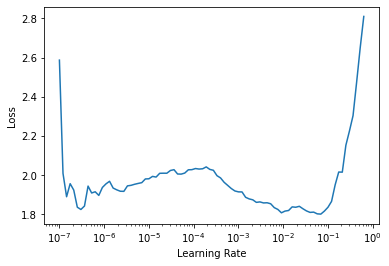

In [44]:
lr = learn_cm.lr_find()

In [45]:
lr = lr.valley
lr

0.006918309628963471

In [46]:
learn_cm.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.651236,0.659730,0.750000,0.877122,0.750000,[0.73404255 0.56756757 0.87096774],00:25
1,1.431123,0.706631,0.722603,0.870845,0.722603,[0.63803681 0.59550562 0.87242798],00:25
2,1.303235,0.643279,0.719178,0.870117,0.719178,[0.63855422 0.52760736 0.89411765],00:25
3,1.167230,0.705480,0.691781,0.855546,0.691781,[0.64285714 0.37878788 0.890625 ],00:25
4,1.079965,0.554620,0.760274,0.894388,0.760274,[0.72340426 0.53900709 0.90980392],00:25
5,1.030749,0.698204,0.691781,0.838902,0.691781,[0.60571429 0.46835443 0.89243028],00:25
6,1.003039,0.584034,0.698630,0.866119,0.698630,[0.53503185 0.49710983 0.93700787],00:25
7,0.963302,0.652081,0.650685,0.847403,0.650685,[0.25 0.55299539 0.90980392],00:25
8,0.953885,0.609434,0.719178,0.871666,0.719178,[0.69565217 0.40601504 0.90983607],00:25
9,0.912010,0.576665,0.753425,0.895107,0.753425,[0.5 0.66990291 0.94488189],00:25


# Interpretation

Here are some prediction results from the test data set:

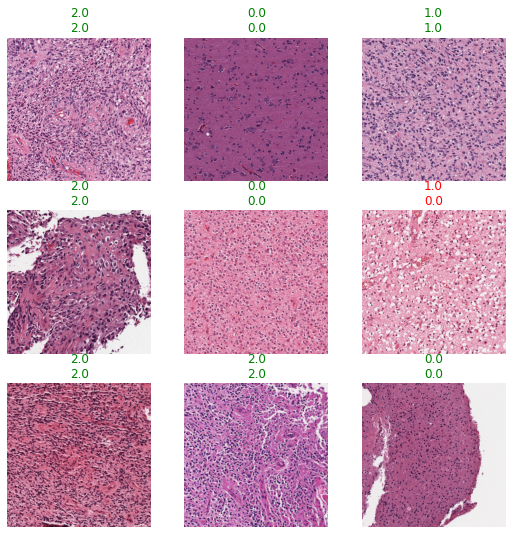

In [66]:
learn.show_results()

The first thing one is interested in is of course how many of the test images the model predicted correctly, and if incorrect, what kind of confusions are there?

In [67]:
interp = ClassificationInterpretation.from_learner(learn)

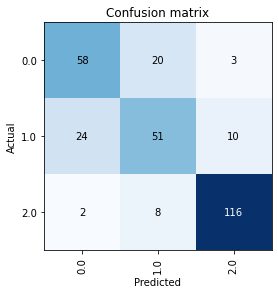

In [68]:
interp.plot_confusion_matrix()

We note that distinguishing grades II and III is difficult for the model, while grade IV is easier. 

## Class activation maps

By extracting the gradients belonging to each of the classes in the data set as they flow into the final convolutional layer in the image, one can produce a heatmap that indicates where in the image the model based its predictions on. 

<img src="assets/gradcam.png">

We'll use the gradCAM implementation from [fastai-amalgam](https://github.com/Synopsis/amalgam). You can have a look [here](https://github.com/Synopsis/amalgam/blob/master/fastai_amalgam/interpret/gradcam.py) for details.

In [ ]:
# See the file `some_utils.py` to check what's imported here
# to compute the gradcam maps.
from some_utils import *

In [ ]:
for img_fn in random.choices(df.imgs.values, k=4):
    gcam = gradcam(learn, str(IMGDATA/img_fn), show_original=True)
    f = plt.figure(figsize=(16,8))
    plt.imshow(gcam)
    plt.axis('off')
    plt.show()

In [ ]:
#%load ../some_utils.py

# Some possible improvements

1. As mentioned above, by aggregating the tumor grade predictions from the multiple views of the same tumor, one can potentially improve the model. Feel free to try.
2. The above grad-CAMs are generated from a single model's activations. By averaging the maps over multiple different models one can be more confident in the estimated importances of the image regions. Feel free to try! You can for example train a couple of models having the same architecture as above, but using a slightly different setup (perhaps even just different seeds for the random number generator). Or you can try multiple different architectures.
3. If you know or come across some other "tricks of the trade" for training CNN models (of which there are many!), feel free to try them out. Using tricks already implemented in fastai is a good starting point as you won't have to dig that much into the underlying PyTorch library.
4. A simple thing to try is to swap the resnet18 model for something larger (or something with other possible advantages). For example `resnet50`, `resnet152`, `squeezenet1_0`, `squeezenet1_1`, `densenet121`, `densenet201`, `vgg11_bn`, or one of the models from https://docs.fast.ai/vision.models.xresnet.html.

# What's next

> One would also want to predict _survival_, not only tumor grade. To do that, one can implement a _Cox layer_ (using the `lifelines` library). See [1] for a possible approach.

Note that we have additional data available for the TCGA subjects. Some available directly from the TCGA data base, others (the RNA data) prepared by [1]:

In [72]:
pd.read_csv(LOCALDATA/'tmidata_100rnaseq_cv_splits.csv').head()

,TCGA ID,Histomolecular subtype,Histology,Grade,Molecular subtype,censored,Survival months,codeletion,idh mutation,EGFR,MDM4,MYC,BRAF,EZH2,MET,SMO,KIAA1549,CREB3L2,NTRK1,PRCC,BLM,NTRK3,CRTC3,CDKN2A,CDKN2B,FGFR2,TSHR,TCL1A,TRIP11,GOLGA5,GPHN,DICER1,TCL6,EBF1,ITK,RPL22,CDKN2C,LCP1,RB1,IRF4,FGFR1OP,MLLT4,MYB,ROS1,TNFAIP3,GOPC,CARD11,JAK2,STK11,PTEN,1q,2p,2q,3p,3q,4p,4q,5p,5q,6p,6q,7p,7q,8p,8q,9p,9q,10p,10q,11p,11q,12p,12q,13q,14q,15q,16p,16q,17p,17q,18p,18q,19p,20p,20q,21q,22q,IDH1_rnaseq,TP53_rnaseq,ATRX_rnaseq,TTN_rnaseq,PTEN_rnaseq,EGFR_rnaseq,CIC_rnaseq,MUC16_rnaseq,PIK3CA_rnaseq,NF1_rnaseq,RYR2_rnaseq,PIK3R1_rnaseq,FUBP1_rnaseq,FLG_rnaseq,PCLO_rnaseq,HMCN1_rnaseq,NOTCH1_rnaseq,PKHD1_rnaseq,SPTA1_rnaseq,LRP2_rnaseq,RB1_rnaseq,KEL_rnaseq,SMARCA4_rnaseq,SYNE1_rnaseq,OBSCN_rnaseq,AHNAK2_rnaseq,DNAH5_rnaseq,FRAS1_rnaseq,MUC17_rnaseq,COL6A3_rnaseq,FAT2_rnaseq,ADGRV1_rnaseq,APOB_rnaseq,IDH2_rnaseq,USH2A_rnaseq,MROH2B_rnaseq,HSPG2_rnaseq,RELN_rnaseq,RYR3_rnaseq,CFAP47_rnaseq,DMD_rnaseq,DNAH8_rnaseq,MYH2_rnaseq,BCOR_rnaseq,DOCK5_rnaseq,DNAH9_rnaseq,GABRA6_rnaseq,LRP1_rnaseq,DNAH11_rnaseq,ZBTB20_rnaseq,DSP_rnaseq,MYH8_rnaseq,TCF12_rnaseq,TCHH_rnaseq,STAG2_rnaseq,NIPBL_rnaseq,MXRA5_rnaseq,CNTNAP2_rnaseq,THSD7B_rnaseq,FBN3_rnaseq,HCN1_rnaseq,CDH18_rnaseq,AFF2_rnaseq,MYH1_rnaseq,NEB_rnaseq,SCN10A_rnaseq,LZTR1_rnaseq,TRPA1_rnaseq,RIMS2_rnaseq,KIF2B_rnaseq,FGD5_rnaseq,SPAG17_rnaseq,ACAN_rnaseq,F5_rnaseq,GRIN2A_rnaseq,PDGFRA_rnaseq,SCN9A_rnaseq,TG_rnaseq,MED12_rnaseq,TENM1_rnaseq,LRP1B_rnaseq,RNF17_rnaseq,NLRP5_rnaseq,FLG2_rnaseq,ACACA_rnaseq,CDH9_rnaseq,COL1A2_rnaseq,FBN2_rnaseq,LAMA3_rnaseq,MUC2_rnaseq,TMPRSS15_rnaseq,SLC1A6_rnaseq,SLIT3_rnaseq,KMT2D_rnaseq,DNAH17_rnaseq,MYH13_rnaseq,ABCC9_rnaseq,ZNF292_rnaseq,PCDH11X_rnaseq,PRDM9_rnaseq,CHD8_rnaseq,CHD9_rnaseq,EPPK1_rnaseq,TMEM132D_rnaseq,ADAMTS16_rnaseq,ADGRF5_rnaseq,ITIH6_rnaseq,FER1L6_rnaseq,MUC5B_rnaseq,PIK3C2G_rnaseq,PLCG2_rnaseq,PTPN11_rnaseq,ROS1_rnaseq,TRRAP_rnaseq,HERC1_rnaseq,KCNB2_rnaseq,SEMA3C_rnaseq,MACF1_rnaseq,SETD2_rnaseq,MYO3A_rnaseq,TRPV6_rnaseq,PCDHA1_rnaseq,TAF1L_rnaseq,ADGRG4_rnaseq,ARID2_rnaseq,LAMA1_rnaseq,DCAF12L2_rnaseq,HRNR_rnaseq,SPATA31D1_rnaseq,CACNA1S_rnaseq,CD22_rnaseq,COL12A1_rnaseq,DNMT3A_rnaseq,DRD5_rnaseq,ENPEP_rnaseq,EPHA3_rnaseq,F8_rnaseq,GRM3_rnaseq,IL4R_rnaseq,ITPR3_rnaseq,KRT15_rnaseq,L1CAM_rnaseq,LAMA2_rnaseq,MKI67_rnaseq,MYH4_rnaseq,MYH11_rnaseq,RPL5_rnaseq,SCN7A_rnaseq,SLC6A3_rnaseq,SVIL_rnaseq,TPO_rnaseq,ALMS1_rnaseq,CUBN_rnaseq,ARID1A_rnaseq,FCGBP_rnaseq,HUWE1_rnaseq,WDFY3_rnaseq,NPAP1_rnaseq,MYO15A_rnaseq,SPTBN5_rnaseq,NLRP2_rnaseq,TENM3_rnaseq,TEX15_rnaseq,DNAH7_rnaseq,FSTL5_rnaseq,TRPC7_rnaseq,ARFGEF3_rnaseq,KMT2C_rnaseq,FAT4_rnaseq,SVEP1_rnaseq,MAP3K19_rnaseq,CALN1_rnaseq,LRRIQ1_rnaseq,NUP210L_rnaseq,NLRP12_rnaseq,PKHD1L1_rnaseq,NLRP3_rnaseq,TMEM132B_rnaseq,PROKR2_rnaseq,LRFN5_rnaseq,PLEKHG4B_rnaseq,FAM47A_rnaseq,SDK1_rnaseq,CD163L1_rnaseq,KSR2_rnaseq,EPHA10_rnaseq,SLC9A4_rnaseq,AFM_rnaseq,BRCA2_rnaseq,C3_rnaseq,FAT1_rnaseq,GABRB2_rnaseq,ITGAX_rnaseq,KDR_rnaseq,KIT_rnaseq,MYO1B_rnaseq,NOTCH2_rnaseq,PTPRZ1_rnaseq,RBBP6_rnaseq,SCN3A_rnaseq,SSTR4_rnaseq,TRPM2_rnaseq,TUBA3C_rnaseq,UGT2B4_rnaseq,COL14A1_rnaseq,VWF_rnaseq,ZNF208_rnaseq,DYSF_rnaseq,MGAM_rnaseq,ATP10B_rnaseq,SYNE2_rnaseq,RIMBP2_rnaseq,CPAMD8_rnaseq,TLR7_rnaseq,RIPK4_rnaseq,UGT2B28_rnaseq,HEATR5B_rnaseq,SAMD9_rnaseq,WWC3_rnaseq,ANO2_rnaseq,TENM2_rnaseq,DPP10_rnaseq,ZDBF2_rnaseq,PRX_rnaseq,ZFHX4_rnaseq,KIAA1109_rnaseq,CARD11_rnaseq,CARD6_rnaseq,TPTE2_rnaseq,GCNA_rnaseq,FAT3_rnaseq,TSHZ2_rnaseq,NLRP4_rnaseq,TEKT4_rnaseq,ABCA13_rnaseq,AMER3_rnaseq,CFAP65_rnaseq,KIF4B_rnaseq,ANO9_rnaseq,PTCHD4_rnaseq,imgs,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15
0,TCGA-06-0125,idhwt_ATC,3,2.0,0,1,1448,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-2.0,-2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.856,0.856,0.0,0.0,0.000,0.000,-0.9

As discussed in the accompanying lecture, one can combine all this data, and also quantifications derived from tumor segmentation using MRI, in single models tasked with predicting tumor grade and overall survival. 

<img width=80% src="assets/pathnet.png">

The presentation gave some pointers for how this can be achieved. 

The next two notebooks provides quick tutorials for the brain segmentation from MRI and the nuclei segmentation parts of the picture. 

# Extra: Feature extraction

As we saw in a previous notebook, one can use _hooks_ to extract the activations generated by feeding data through a neural network. 

In the current case, such activations from the final hidden layer can be used for a model tasked with predicting tumor grade or overall survival from different sources, as discussed in the lecture. 

I'll add code for extracting the activations here, in case you want to play around with it on your own.

In [86]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [87]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=512, bias=False)

In [88]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

In [89]:
img, c = dls.valid_ds[0]

In [90]:
img, c

(PILImage mode=RGB size=1024x1024, TensorCategory(2))

In [91]:
with torch.no_grad(): 
        output = learn.predict(img)

In [92]:
acts = np.array(hook_output.stored.cpu())[0]

In [93]:
acts.shape

(512,)

In [94]:
acts

array([-20.11  , -28.66  ,   3.39  ,  -3.658 , -18.08  ,  -6.38  ,
       -21.95  , -20.5   , -16.8   ,  11.38  ,   5.27  ,   5.82  ,
        -1.406 ,  10.266 , -11.305 ,   3.867 ,  -2.03  ,   9.93  ,
         4.508 , -17.08  ,   3.209 , -12.4   ,  15.945 ,  -8.31  ,
       -14.62  ,  -7.27  ,  11.8   , -19.66  ,  10.375 ,  11.93  ,
         5.945 ,   4.74  , -14.    ,   8.2   ,  11.914 , -13.22  ,
        21.84  ,   5.34  ,  -5.61  ,  15.734 ,   6.918 ,   5.457 ,
       -24.88  , -18.12  , -19.92  ,  10.28  ,  16.58  , -10.99  ,
         0.2067,  12.17  ,  -6.035 , -12.34  ,  13.61  ,   4.28  ,
         8.02  , -10.7   ,   6.926 ,   2.17  ,  16.28  ,  13.4   ,
         0.9473,  -0.43  ,  -7.902 ,  10.39  ,  16.14  , -14.445 ,
       -14.13  ,   5.09  ,   8.49  ,  13.    ,   6.516 ,  12.91  ,
         0.4468, -12.734 , -27.36  ,  -9.19  ,  -1.418 ,  -6.69  ,
       -12.484 , -10.96  , -16.08  ,   8.25  ,   9.43  , -17.33  ,
        -9.086 , -11.07  ,  17.8   ,   1.431 ,  -1.057 ,  -4.7

# Extra: Cross-validation setup and comparison with the results of [1]

Note that to compare our grade prediction results with [1] we need to use the same validation setup as them. We can achieve this by training and evaluating our model 15 times on the 15 different cross validation folds determined by [1] and [2]. 

In [24]:
df.head()

,TCGA ID,Histomolecular subtype,Histology,Grade,Molecular subtype,censored,Survival months,imgs,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15,is_valid
3,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,False
4,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,False
5,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX1.6171b175-0972-4e84-9997-2f1ce75f4407_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,False
6,TCGA-02-0006,idhwt_ATC,3,2.0,0,1,558,TCGA-02-0006-01Z-00-DX1.a37df719-8b93-4245-ae49-67eb1114253a_1.png,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,False
7,TCGA-02-0007,idhwt_ATC,3,2.0,0,1,705,TCGA-02-0007-01Z-00-DX1.a888f75e-6c41-44c3-8eb6-721f992873b8_1.png,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,False


Let's make a function to train and evaluate models on the different cross validation folds:

In [27]:
def train_evaluate_model(df, cv_iter, n_epochs=10, show_plot=False):
    """
    Train the model on the provided training data
    Evaluate on the test data.
    
    Inputs:
        df: a dataframe of images and grades, with validation data
            set by the corresponding cv column
            
    Outputs:
        learn: the trained learner
        metrics: the metrics (acc, rocauc, f1) computed on the validation set
    """
    
    assert cv_iter in range(1,16), "cv_iter must be between 1 and 15"
    
    dls = ImageDataLoaders.from_df(
        df, path=IMGDATA, fn_col='imgs', label_col='Grade', 
        valid_col=f'cv_{cv_iter}',
        item_tfms=Resize(1024, method='zeros'), 
        batch_tfms=[Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), 
                    Normalize.from_stats(*imagenet_stats), 
                    Resize(900, method='zeros')])
    
    print(f"Cross validation fold # {cv_iter}")
    print(f"Training on {len(dls.items)} validating on {len(dls.valid_ds.items)}\n")
    
    
    learn = cnn_learner(dls, 
                    arch=resnet18, 
                    metrics=[accuracy, RocAuc(), F1Score(average='micro'), F1Score(average=None)], 
                    path='.', 
                    pretrained=True, wd=1e-4).to_fp16()
    
    print(f"Finding the learning rate:")
    _, lr = learn.lr_find(suggestions=True, show_plot=False)
    print(f"Using learning rate {lr}\n")
    
    print(f"Training for {n_epochs} epochs...\n")
    
    learn.fine_tune(n_epochs, lr)
    
    print(f"Evaluating on the validation data...\n")
    
    if show_plot:
        learn.recorder.plot_metrics()
        plt.show()
        
    metrics = list(learn.validate())
    
    print(
        f"Accuracy: {metrics[1]}. ROCAUC: {metrics[2]}", 
        f"F1 score: {metrics[3]}, F1 score grade IV: {metrics[4][-1]}"
        )
    
    # Free up GPU memory after training
    learn = None
    dls = None
    gc.collect()
    torch.cuda.empty_cache()
    
    return metrics

In [29]:
%%time
cv_metrics = {}
for cv_iter in range(1,16):
    metrics = train_evaluate_model(df, cv_iter)
    cv_metrics[cv_iter] = metrics
    print("#"*40)
    print()

Cross validation fold # 1
Training on 1204 validating on 254

Finding the learning rate:


Using learning rate 0.006918309628963471

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.444341,2.280333,0.437008,0.720136,0.437008,[0.41558442 0.2 0.62745098],00:24


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.896245,0.710132,0.759843,0.880847,0.759843,[0.51546392 0.58914729 0.92198582],00:28
1,0.777228,0.888850,0.716535,0.869944,0.716535,[0.5511811 0.44444444 0.91666667],00:28
2,0.701699,0.712663,0.779528,0.890213,0.779528,[0.57777778 0.65248227 0.90974729],00:28
3,0.640690,0.864982,0.736220,0.890866,0.736220,[0.52427184 0.46846847 0.91156463],00:28
4,0.584602,0.719621,0.720472,0.878311,0.720472,[0.51612903 0.575 0.88627451],00:28
5,0.517513,0.658308,0.755906,0.901194,0.755906,[0.26470588 0.62820513 0.94366197],00:28
6,0.451950,0.666352,0.748031,0.890083,0.748031,[0.4516129 0.60273973 0.92936803],00:28
7,0.404026,0.670673,0.748031,0.895264,0.748031,[0.48421053 0.57142857 0.93040293],00:28
8,0.356284,0.617843,0.775591,0.897872,0.775591,[0.54166667 0.60869565 0.94160584],00:28
9,0.309375,0.611785,0.771654,0.899275,0.771654,[0.52631579 0.60992908 0.94117647],00:28


Evaluating on the validation data...



Accuracy: 0.7716535329818726. ROCAUC: 0.8992752391322284 F1 score: 0.7716535433070866, F1 score grade IV: 0.9411764705882353
########################################

Cross validation fold # 2
Training on 1149 validating on 309

Finding the learning rate:


Using learning rate 0.00831763744354248

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.271250,2.196390,0.546926,0.803342,0.546926,[0.57692308 0.35928144 0.65020576],00:24


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.889837,0.805475,0.737864,0.876368,0.737864,[0.65432099 0.39669421 0.90149254],00:28
1,0.790360,0.826867,0.673139,0.867662,0.673139,[0.57142857 0.5 0.8409894 ],00:28
2,0.708459,0.830482,0.711974,0.865868,0.711974,[0.63235294 0.51136364 0.8627451 ],00:28
3,0.682352,0.739579,0.757282,0.895679,0.757282,[0.48543689 0.62857143 0.90588235],00:28
4,0.594202,0.625266,0.750809,0.894979,0.750809,[0.56692913 0.53947368 0.91445428],00:28
5,0.536573,0.633256,0.779935,0.899168,0.779935,[0.68456376 0.58974359 0.9201278 ],00:28
6,0.471771,0.617246,0.766990,0.911318,0.766990,[0.62857143 0.54014599 0.91495601],00:28
7,0.411150,0.530551,0.776699,0.909003,0.776699,[0.60606061 0.63030303 0.92211838],00:28
8,0.360213,0.577544,0.783172,0.905632,0.783172,[0.6442953 0.58333333 0.93538462],00:28
9,0.320676,0.574122,0.779935,0.907741,0.779935,[0.61538462 0.57931034 0.93939394],00:28


Evaluating on the validation data...



Accuracy: 0.7799353003501892. ROCAUC: 0.9077414008679751 F1 score: 0.7799352750809061, F1 score grade IV: 0.9393939393939394
########################################

Cross validation fold # 3
Training on 1146 validating on 312

Finding the learning rate:


Using learning rate 0.010000000149011612

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.401607,1.318732,0.657051,0.849509,0.657051,[0.70046083 0.47126437 0.75536481],00:24


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.867866,0.836762,0.743590,0.881360,0.743590,[0.6163522 0.56470588 0.91525424],00:28
1,0.800694,0.745363,0.727564,0.873792,0.727564,[0.65868263 0.52694611 0.88275862],00:28
2,0.714387,0.836542,0.660256,0.859533,0.660256,[0.35483871 0.51886792 0.89583333],00:28
3,0.644833,0.581367,0.730769,0.885836,0.730769,[0.69473684 0.43971631 0.89419795],00:28
4,0.584993,0.678688,0.669872,0.876304,0.669872,[0.47222222 0.48087432 0.88215488],00:28
5,0.529532,0.570889,0.762821,0.900236,0.762821,[0.6440678 0.58536585 0.93992933],00:28
6,0.469954,0.549826,0.762821,0.912358,0.762821,[0.60402685 0.63265306 0.9390681 ],00:28
7,0.405034,0.560533,0.733974,0.897181,0.733974,[0.61988304 0.5375 0.90784983],00:28
8,0.350818,0.519456,0.766026,0.913278,0.766026,[0.70391061 0.57861635 0.90909091],00:28
9,0.310641,0.516904,0.778846,0.914469,0.778846,[0.72222222 0.59354839 0.91349481],00:28


Evaluating on the validation data...



Accuracy: 0.7788461446762085. ROCAUC: 0.9144689038523612 F1 score: 0.7788461538461539, F1 score grade IV: 0.9134948096885813
########################################

Cross validation fold # 4
Training on 1203 validating on 255

Finding the learning rate:


Using learning rate 0.006918309628963471

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.327566,1.398450,0.631373,0.812881,0.631373,[0.53503185 0.39669421 0.81896552],00:26


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.922478,0.907431,0.737255,0.874277,0.737255,[0.71328671 0.576 0.83471074],00:28
1,0.792993,0.860388,0.662745,0.849852,0.662745,[0.5 0.44594595 0.85826772],00:28
2,0.687581,0.699489,0.780392,0.897116,0.780392,[0.71317829 0.56198347 0.91538462],00:28
3,0.637635,0.852905,0.741176,0.880093,0.741176,[0.60176991 0.49206349 0.91512915],00:28
4,0.562101,0.549664,0.788235,0.918893,0.788235,[0.71428571 0.55462185 0.92830189],00:28
5,0.502212,0.594501,0.749020,0.905275,0.749020,[0.67164179 0.528 0.90039841],00:28
6,0.436083,0.611717,0.752941,0.903331,0.752941,[0.59322034 0.57142857 0.91891892],00:28
7,0.381765,0.607987,0.768627,0.904725,0.768627,[0.59259259 0.57777778 0.93632959],00:28
8,0.333140,0.616716,0.780392,0.907567,0.780392,[0.65 0.6 0.93076923],00:28
9,0.301653,0.633208,0.756863,0.905439,0.756863,[0.60869565 0.58992806 0.9140625 ],00:28


Evaluating on the validation data...



Accuracy: 0.7568627595901489. ROCAUC: 0.9054388614281853 F1 score: 0.7568627450980392, F1 score grade IV: 0.9140625
########################################

Cross validation fold # 5
Training on 1168 validating on 290

Finding the learning rate:


Using learning rate 0.010000000149011612

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.327268,1.290706,0.682759,0.845930,0.682759,[0.67661692 0.4966443 0.80869565],00:26


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.950392,0.752288,0.727586,0.879062,0.727586,[0.69273743 0.36521739 0.8951049 ],00:29
1,0.778525,0.646686,0.734483,0.885091,0.734483,[0.53731343 0.57142857 0.92805755],00:29
2,0.693031,0.831209,0.734483,0.894471,0.734483,[0.5625 0.56969697 0.90592334],00:28
3,0.632320,0.567510,0.765517,0.901275,0.765517,[0.71345029 0.52173913 0.92250923],00:29
4,0.587027,0.657379,0.720690,0.883920,0.720690,[0.46666667 0.60824742 0.91729323],00:29
5,0.543604,0.575291,0.772414,0.906058,0.772414,[0.68421053 0.58441558 0.9270073 ],00:29
6,0.467503,0.547177,0.768966,0.908020,0.768966,[0.61870504 0.62068966 0.94382022],00:28
7,0.407976,0.541101,0.779310,0.915202,0.779310,[0.61428571 0.63529412 0.95555556],00:29
8,0.351755,0.577315,0.772414,0.907115,0.772414,[0.58571429 0.62352941 0.96296296],00:29
9,0.310685,0.570213,0.775862,0.908001,0.775862,[0.6013986 0.62275449 0.96296296],00:29


Evaluating on the validation data...



Accuracy: 0.7758620977401733. ROCAUC: 0.9080014435972134 F1 score: 0.7758620689655173, F1 score grade IV: 0.9629629629629629
########################################

Cross validation fold # 6
Training on 1180 validating on 278

Finding the learning rate:


Using learning rate 0.002290867641568184

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.309238,1.058932,0.640288,0.827058,0.640288,[0.65979381 0.4125 0.8019802 ],00:26


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.894645,0.822908,0.629496,0.835772,0.629496,[0.47682119 0.4673913 0.86877828],00:29
1,0.797795,0.745167,0.712230,0.877135,0.712230,[0.68208092 0.53012048 0.87557604],00:28
2,0.739136,0.762884,0.712230,0.858970,0.712230,[0.67724868 0.46031746 0.87136929],00:28
3,0.679198,0.756636,0.687050,0.864180,0.687050,[0.53691275 0.53409091 0.9004329 ],00:28
4,0.619485,0.776225,0.687050,0.865071,0.687050,[0.6010929 0.42647059 0.90295359],00:28
5,0.572079,0.751812,0.687050,0.872040,0.687050,[0.55405405 0.54644809 0.88888889],00:28
6,0.521419,0.636814,0.726619,0.888216,0.726619,[0.64772727 0.5170068 0.91845494],00:28
7,0.468936,0.678266,0.723022,0.875466,0.723022,[0.60869565 0.54658385 0.92307692],00:28
8,0.431979,0.650174,0.726619,0.883095,0.726619,[0.62195122 0.53846154 0.92372881],00:28
9,0.399891,0.651320,0.737410,0.884083,0.737410,[0.63855422 0.55345912 0.93506494],00:28


Evaluating on the validation data...



Accuracy: 0.7374100685119629. ROCAUC: 0.8840834694078618 F1 score: 0.737410071942446, F1 score grade IV: 0.9350649350649352
########################################

Cross validation fold # 7
Training on 1186 validating on 272

Finding the learning rate:


Using learning rate 0.010000000149011612

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.399772,1.230358,0.632353,0.836314,0.632353,[0.59756098 0.47619048 0.78301887],00:25


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.908519,0.819766,0.702206,0.846635,0.702206,[0.67080745 0.43478261 0.87346939],00:29
1,0.716969,0.612586,0.727941,0.893325,0.727941,[0.54814815 0.54901961 0.9296875 ],00:28
2,0.674150,0.704034,0.735294,0.879307,0.735294,[0.63354037 0.51428571 0.93004115],00:28
3,0.608295,0.615569,0.750000,0.897161,0.750000,[0.64102564 0.52554745 0.94023904],00:28
4,0.546866,0.796591,0.724265,0.887482,0.724265,[0.55172414 0.55033557 0.88888889],00:28
5,0.491049,0.613883,0.757353,0.898558,0.757353,[0.68322981 0.52713178 0.92125984],00:28
6,0.428128,0.621027,0.761029,0.898774,0.761029,[0.63945578 0.61538462 0.92946058],00:28
7,0.382367,0.760590,0.724265,0.877397,0.724265,[0.57364341 0.57317073 0.90039841],00:28
8,0.331065,0.697304,0.757353,0.892538,0.757353,[0.63703704 0.60645161 0.91338583],00:28
9,0.294092,0.709415,0.761029,0.891644,0.761029,[0.62686567 0.61538462 0.92125984],00:28


Evaluating on the validation data...



Accuracy: 0.7610294222831726. ROCAUC: 0.8916444781756082 F1 score: 0.761029411764706, F1 score grade IV: 0.921259842519685
########################################

Cross validation fold # 8
Training on 1191 validating on 267

Finding the learning rate:


Using learning rate 0.010000000149011612

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.334757,2.850617,0.509363,0.751824,0.509363,[0.53968254 0.32467532 0.62827225],00:25


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.983720,1.266088,0.595506,0.824193,0.595506,[0.48739496 0.51674641 0.73786408],00:29
1,0.816468,0.825971,0.692884,0.856827,0.692884,[0.576 0.47826087 0.85608856],00:28
2,0.684075,0.786794,0.689139,0.863805,0.689139,[0.43137255 0.54761905 0.87878788],00:28
3,0.623621,0.678284,0.715356,0.873037,0.715356,[0.48695652 0.56969697 0.91338583],00:28
4,0.551885,0.766313,0.685393,0.865649,0.685393,[0.29885057 0.56353591 0.89473684],00:28
5,0.490669,0.827310,0.681648,0.857699,0.681648,[0.52892562 0.56216216 0.85964912],00:28
6,0.438580,0.688331,0.704120,0.875754,0.704120,[0.49557522 0.53416149 0.9 ],00:28
7,0.387830,0.689965,0.722846,0.881116,0.722846,[0.46153846 0.58181818 0.91320755],00:28
8,0.344415,0.689935,0.745318,0.885836,0.745318,[0.53097345 0.59627329 0.93076923],00:28
9,0.308319,0.686264,0.741573,0.885609,0.741573,[0.51785714 0.59393939 0.93385214],00:28


Evaluating on the validation data...



Accuracy: 0.7415730357170105. ROCAUC: 0.885608650746446 F1 score: 0.7415730337078652, F1 score grade IV: 0.933852140077821
########################################

Cross validation fold # 9
Training on 1156 validating on 302

Finding the learning rate:


Using learning rate 0.010000000149011612

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.337472,1.488085,0.632450,0.822207,0.632450,[0.66382979 0.44311377 0.75247525],00:26


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.817138,1.062094,0.635762,0.828420,0.635762,[0.66972477 0.42774566 0.76995305],00:29
1,0.723679,0.940155,0.655629,0.841902,0.655629,[0.51612903 0.47058824 0.87022901],00:29
2,0.658539,0.697467,0.731788,0.885420,0.731788,[0.68508287 0.57754011 0.88983051],00:29
3,0.596270,0.768526,0.715232,0.878028,0.715232,[0.67045455 0.48684211 0.86956522],00:29
4,0.544873,0.619768,0.735099,0.890828,0.735099,[0.6779661 0.57923497 0.89344262],00:29
5,0.490102,0.650488,0.728477,0.889990,0.728477,[0.62721893 0.59793814 0.90456432],00:29
6,0.424763,0.631745,0.758278,0.899655,0.758278,[0.71356784 0.6035503 0.90677966],00:29
7,0.366441,0.665347,0.738411,0.891960,0.738411,[0.61904762 0.63636364 0.90756303],00:29
8,0.320102,0.623362,0.758278,0.901459,0.758278,[0.67428571 0.63829787 0.91286307],00:29
9,0.279417,0.606363,0.761589,0.906014,0.761589,[0.69230769 0.62569832 0.91358025],00:29


Evaluating on the validation data...



Accuracy: 0.7615894079208374. ROCAUC: 0.9060144531974005 F1 score: 0.76158940397351, F1 score grade IV: 0.9135802469135802
########################################

Cross validation fold # 10
Training on 1190 validating on 268

Finding the learning rate:


Using learning rate 0.012022644281387329

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.411443,2.026290,0.544776,0.793006,0.544776,[0.44827586 0.50691244 0.64039409],00:25


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.907972,0.864125,0.667910,0.863880,0.667910,[0.41584158 0.54237288 0.85271318],00:29
1,0.776983,1.066175,0.679105,0.853026,0.679104,[0.57931034 0.5 0.85957447],00:28
2,0.712011,0.663577,0.750000,0.900739,0.750000,[0.63551402 0.61988304 0.88372093],00:28
3,0.620738,0.783718,0.694030,0.868459,0.694030,[0.62773723 0.51282051 0.84773663],00:28
4,0.568703,0.709072,0.720149,0.875949,0.720149,[0.50406504 0.52413793 0.92537313],00:28
5,0.521399,0.777215,0.735075,0.884370,0.735075,[0.58267717 0.47540984 0.91289199],00:28
6,0.459372,0.617904,0.746269,0.896238,0.746269,[0.48598131 0.60606061 0.93939394],00:28
7,0.402902,0.672663,0.761194,0.889932,0.761194,[0.56666667 0.60526316 0.93939394],00:28
8,0.345984,0.712210,0.750000,0.877902,0.750000,[0.56198347 0.58823529 0.93129771],00:28
9,0.302848,0.708987,0.750000,0.880438,0.750000,[0.54237288 0.59872611 0.9348659 ],00:28


Evaluating on the validation data...



Accuracy: 0.75. ROCAUC: 0.8804376008329124 F1 score: 0.75, F1 score grade IV: 0.9348659003831418
########################################

Cross validation fold # 11
Training on 1141 validating on 317

Finding the learning rate:


Using learning rate 0.006918309628963471

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.297132,1.600575,0.542587,0.770525,0.542587,[0.57758621 0.34693878 0.68932039],00:26


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.829074,0.921189,0.649842,0.830425,0.649842,[0.59192825 0.37037037 0.88353414],00:28
1,0.726973,0.961315,0.709779,0.861939,0.709779,[0.65486726 0.4084507 0.91729323],00:28
2,0.676361,0.819160,0.728707,0.873173,0.728707,[0.62886598 0.5433526 0.92134831],00:28
3,0.619377,0.896224,0.700315,0.869917,0.700315,[0.65822785 0.35555556 0.91603053],00:28
4,0.559411,0.660483,0.709779,0.872398,0.709779,[0.58823529 0.53551913 0.91666667],00:28
5,0.499692,0.709430,0.716088,0.885356,0.716088,[0.5952381 0.56701031 0.89705882],00:28
6,0.439942,0.664667,0.728707,0.887165,0.728707,[0.59302326 0.58706468 0.92720307],00:28
7,0.393144,0.747556,0.712934,0.877451,0.712934,[0.5862069 0.55026455 0.90774908],00:28
8,0.338704,0.719391,0.741325,0.881540,0.741325,[0.63829787 0.58823529 0.92664093],00:28
9,0.297135,0.717098,0.744479,0.881692,0.744479,[0.64583333 0.58378378 0.93385214],00:28


Evaluating on the validation data...



Accuracy: 0.7444794774055481. ROCAUC: 0.8816918873166664 F1 score: 0.7444794952681388, F1 score grade IV: 0.933852140077821
########################################

Cross validation fold # 12
Training on 1188 validating on 270

Finding the learning rate:


Using learning rate 0.004786301031708717

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.315569,1.423663,0.581481,0.816486,0.581481,[0.56084656 0.41428571 0.71090047],00:25


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.888121,0.764263,0.748148,0.866841,0.748148,[0.6 0.59602649 0.91119691],00:29
1,0.774848,0.670089,0.711111,0.869920,0.711111,[0.54676259 0.49275362 0.91254753],00:28
2,0.717624,0.891203,0.711111,0.853083,0.711111,[0.54411765 0.52348993 0.90980392],00:28
3,0.665505,0.706738,0.755556,0.898905,0.755556,[0.63309353 0.59722222 0.91050584],00:28
4,0.599304,0.747845,0.718518,0.875968,0.718519,[0.42990654 0.5862069 0.92664093],00:28
5,0.524261,0.689255,0.770370,0.891739,0.770370,[0.64615385 0.6056338 0.91791045],00:28
6,0.451569,0.679949,0.762963,0.891030,0.762963,[0.56198347 0.62420382 0.9389313 ],00:28
7,0.395360,0.704165,0.774074,0.892603,0.774074,[0.58536585 0.62666667 0.94382022],00:28
8,0.353090,0.715990,0.774074,0.893190,0.774074,[0.58064516 0.62666667 0.94736842],00:28
9,0.313441,0.729050,0.774074,0.893154,0.774074,[0.592 0.62162162 0.94382022],00:28


Evaluating on the validation data...



Accuracy: 0.7740740776062012. ROCAUC: 0.893154189491463 F1 score: 0.774074074074074, F1 score grade IV: 0.9438202247191011
########################################

Cross validation fold # 13
Training on 1176 validating on 282

Finding the learning rate:


Using learning rate 0.00831763744354248

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.422495,1.410435,0.599291,0.795095,0.599291,[0.5 0.32116788 0.82071713],00:26


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.839997,0.795358,0.758865,0.871275,0.758865,[0.67901235 0.51239669 0.91103203],00:29
1,0.783304,0.943514,0.709220,0.861514,0.709220,[0.53333333 0.46808511 0.89108911],00:28
2,0.715886,0.873641,0.698582,0.865750,0.698582,[0.65838509 0.43055556 0.87258687],00:28
3,0.652378,0.635122,0.726950,0.901421,0.726950,[0.61788618 0.58285714 0.87218045],00:28
4,0.601532,0.728332,0.751773,0.891969,0.751773,[0.544 0.55072464 0.93023256],00:28
5,0.531983,0.593107,0.758865,0.897774,0.758865,[0.60740741 0.57534247 0.92579505],00:29
6,0.455875,0.693240,0.712766,0.886733,0.712766,[0.62068966 0.50331126 0.88059701],00:28
7,0.393455,0.726707,0.712766,0.878937,0.712766,[0.43478261 0.54545455 0.92253521],00:28
8,0.340454,0.661800,0.762411,0.892673,0.762411,[0.60606061 0.59354839 0.93140794],00:28
9,0.302749,0.628599,0.765957,0.898605,0.765957,[0.60465116 0.5974026 0.93238434],00:29


Evaluating on the validation data...



Accuracy: 0.7659574747085571. ROCAUC: 0.8986052424021941 F1 score: 0.7659574468085105, F1 score grade IV: 0.9323843416370106
########################################

Cross validation fold # 14
Training on 1171 validating on 287

Finding the learning rate:


Using learning rate 0.006918309628963471

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.219524,1.953897,0.550523,0.783429,0.550523,[0.58139535 0.42156863 0.65656566],00:26


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.877030,1.132670,0.700348,0.836159,0.700348,[0.60818713 0.525 0.88065844],00:29
1,0.759970,1.083477,0.662021,0.850805,0.662021,[0.55757576 0.34328358 0.88 ],00:28
2,0.661909,0.847336,0.675958,0.851349,0.675958,[0.56969697 0.46153846 0.87747036],00:28
3,0.617944,1.124108,0.630662,0.803158,0.630662,[0.47552448 0.52 0.82251082],00:28
4,0.551028,0.898114,0.700348,0.851887,0.700348,[0.5 0.55737705 0.89138577],00:29
5,0.492903,0.869834,0.693380,0.870157,0.693380,[0.57142857 0.52380952 0.87258687],00:28
6,0.439099,0.756037,0.696864,0.864491,0.696864,[0.45528455 0.55319149 0.91254753],00:29
7,0.372030,0.774536,0.686411,0.863220,0.686411,[0.54545455 0.49101796 0.90118577],00:28
8,0.317135,0.793766,0.672474,0.861806,0.672474,[0.52631579 0.46706587 0.89411765],00:29
9,0.279285,0.796946,0.675958,0.863082,0.675958,[0.52631579 0.46987952 0.8984375 ],00:28


Evaluating on the validation data...



Accuracy: 0.6759582161903381. ROCAUC: 0.8630816231180939 F1 score: 0.6759581881533101, F1 score grade IV: 0.8984375
########################################

Cross validation fold # 15
Training on 1193 validating on 265

Finding the learning rate:


Using learning rate 0.010000000149011612

Training for 10 epochs...



epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.235107,1.445043,0.603774,0.826928,0.603774,[0.43859649 0.50810811 0.76190476],00:25


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.934371,1.421850,0.603774,0.827099,0.603774,[0.54545455 0.51648352 0.71296296],00:29
1,0.793860,0.831478,0.735849,0.868841,0.735849,[0.56692913 0.52307692 0.91575092],00:28
2,0.739712,0.728524,0.739623,0.875530,0.739623,[0.58333333 0.51515152 0.91366906],00:28
3,0.648212,0.872875,0.720755,0.867640,0.720755,[0.55855856 0.52054795 0.89377289],00:28
4,0.568421,0.763427,0.709434,0.881469,0.709434,[0.576 0.48951049 0.89312977],00:28
5,0.496280,0.599306,0.739623,0.893544,0.739623,[0.51851852 0.59060403 0.90842491],00:28
6,0.437203,0.589385,0.766038,0.894234,0.766038,[0.57657658 0.6013986 0.92753623],00:28
7,0.374761,0.607552,0.769811,0.897971,0.769811,[0.59813084 0.63636364 0.91449814],00:28
8,0.329644,0.593750,0.781132,0.902357,0.781132,[0.59813084 0.64900662 0.92647059],00:28
9,0.289920,0.592885,0.777358,0.902579,0.777358,[0.59259259 0.64900662 0.92250923],00:28


Evaluating on the validation data...



Accuracy: 0.7773584723472595. ROCAUC: 0.9025788015730214 F1 score: 0.7773584905660378, F1 score grade IV: 0.9225092250922509
########################################

CPU times: user 51min 50s, sys: 23min 45s, total: 1h 15min 36s
Wall time: 1h 45min 5s


...and store the results:

In [30]:
rocauc = [m[2] for m in cv_metrics.values()]
f1 = [m[3] for m in cv_metrics.values()]
f1_iv = [m[4][-1] for m in cv_metrics.values()]

In [31]:
# Compute means and standard deviations
print(f"Mean rocauc {np.mean(rocauc).round(3)}, std rocauc {np.std(rocauc).round(3)}")
print(f"Mean F1 score {np.mean(f1).round(3)}, std F1 score {np.std(f1).round(3)}")
print(f"F1 score for grade IV {np.mean(f1_iv).round(3)}, std F1 score grade IV {np.std(f1_iv).round(3)}")

Mean rocauc 0.895, std rocauc 0.013
Mean F1 score 0.757, std F1 score 0.026
F1 score for grade IV 0.929, std F1 score grade IV 0.015


Here are the results of the TMI paper [1] for comparison:

<img width=80% src="assets/TMI-grade-results.png">

> Of course, in our cross-validation setup we didn't use any of the tricks we looked at above (progressive resizing, test-time-augmentation, MixUp), and we didn't consider how to best label the multiview histology data belonging to a single grade. Feel free to give it a go if you have the time and computational resources. :-)